In [62]:
%matplotlib inline
import imp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import seaborn as sns; sns.set()
from copy import deepcopy
import catboost as cgb
import imp
from bayes_opt import BayesianOptimization
from sklearn.datasets import load_boston
from skopt.space import Real, Categorical, Integer
from sklearn.metrics import r2_score , mean_squared_error
import lightgbm
from scipy.interpolate import interp1d
url="C:/Users/louis/Downloads/Projet/"

In [63]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

hide_toggle()

In [64]:
def _haversine_distance(lat_A, lon_A, lat_B, lon_B):
    earth_radius = 6373
    distance = np.sin((lat_B - lat_A) / 2) ** 2 + np.cos(lat_A) * \
               np.cos(lat_B) * np.sin((lon_B - lon_A) / 2) ** 2
    distance = 2 * earth_radius * np.arcsin(distance)
    return distance



problem = imp.load_source('', 'problem.py')
X_df, y_array = problem.get_train_data()
X_encoded = X_df

url="C:/Users/louis/Downloads/Projet/"
final = pd.read_csv(url+"Ajout_données.csv")
final["Date"]=pd.to_datetime(final["Date"])

X_encoded['DateOfDeparture'] = pd.to_datetime(X_encoded['DateOfDeparture'])
X_encoded['year'] = X_encoded['DateOfDeparture'].dt.year
X_encoded['month'] = X_encoded['DateOfDeparture'].dt.month
X_encoded['day'] = X_encoded['DateOfDeparture'].dt.day
X_encoded['weekday'] = X_encoded['DateOfDeparture'].dt.weekday
X_encoded['week'] = X_encoded['DateOfDeparture'].dt.week
X_encoded['n_days'] = X_encoded['DateOfDeparture'].apply(lambda date: (date -pd.to_datetime("1970-01-01")).days)
X_df_Depart = X_encoded.drop("Arrival", axis=1)
X_df_Arrivee = X_encoded.drop("Departure", axis=1)


fusion_depart = X_df_Depart.merge(final.add_suffix('_depart'),how="left", \
left_on=["DateOfDeparture","Departure"],right_on=["Date_depart","AirPort_depart"])
fusion_arrivee = X_df_Arrivee.merge(final.add_suffix('_arrivee'),how="left",\
left_on=["DateOfDeparture","Arrival"],right_on=["Date_arrivee","AirPort_arrivee"])
fusion_arrivee=fusion_arrivee.drop(["DateOfDeparture","WeeksToDeparture",\
                                                          "std_wtd","year","month","day","weekday","week","n_days"],axis=1)
perfect = fusion_depart.merge(fusion_arrivee, left_index=True, right_index=True)

perfect["Precipitationmm_arrivee"]=np.where(perfect["Precipitationmm_arrivee"] == 'T',0,perfect["Precipitationmm_arrivee"])
perfect["Events_arrivee"]=perfect["Events_arrivee"].fillna("Sunny")
perfect["Precipitationmm_depart"]=np.where(perfect["Precipitationmm_depart"] == 'T',0,perfect["Precipitationmm_depart"])
perfect["Events_depart"]=perfect["Events_depart"].fillna("Sunny")
#perfect = perfect.join(pd.get_dummies(perfect['Events_depart'], prefix='d'))
#perfect = perfect.join(pd.get_dummies(perfect['Events_arrivee'], prefix='a'))
#perfect = perfect.drop('Events_depart', axis=1)
#perfect = perfect.drop('Events_arrivee', axis=1)
liste_flo = ["lat_arrivee","lon_arrivee","Precipitationmm_arrivee","lat_depart","lon_depart","Precipitationmm_depart"]
perfect[liste_flo]=perfect[liste_flo].astype(float)
perfect['distance'] = _haversine_distance(\
              perfect['lat_arrivee'].values,\
              perfect['lon_arrivee'].values,\
              perfect['lat_depart'].values,\
              perfect['lon_depart'].values)
del perfect["DateOfDeparture"]
perfect=perfect.drop(["DateOfDeparture_arrivee","Date_depart",\
          "DateOfDeparture_depart","Date_arrivee","City_arrivee",\
          "State_arrivee","City_depart","State_depart","AirPort_arrivee",\
          "AirPort_depart","is_weekend_depart","is_holiday_depart",\
          "is_close_from_weekend_or_holiday_depart"],axis=1)
perfect = perfect.rename(columns={'is_weekend_arrivee': 'is_weekend',\
          'is_holiday_arrivee':'is_holiday',\
          'is_close_from_weekend_or_holiday_arrivee':'is_close_from_weekend_or_holiday'})
#perfect=perfect.drop([c for c, d in zip (perfect.columns,perfect.dtypes) if d==np.object],axis=1)
#perfect = perfect.join(pd.get_dummies(perfect['Departure'], prefix='d'))
#perfect = perfect.join(pd.get_dummies(X_encoded['Arrival'], prefix='a'))
#perfect = perfect.drop('Departure', axis=1)
#perfect = perfect.drop('Arrival', axis=1)
for i in [c for c, d in zip (perfect.columns,perfect.dtypes) if d==np.bool] :
            perfect[i]=np.where(perfect[i] == False,0,1)   

hide_toggle()

### CatBoost non tuné

In [65]:
from sklearn.model_selection import train_test_split
import numpy as np
perfect["log_PAX"] = y_array
y = perfect["log_PAX"]
X = perfect.drop(["log_PAX"], axis=1)
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=0)
cat_algo =[c for c, d in zip (X.columns,X.dtypes) if d==np.object]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
        test_size=0.15, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=0)

from catboost import Pool, CatBoostRegressor, cv,CatBoostClassifier

train_pool = Pool(data =X_train, label = y_train, cat_features=X[cat_algo])

validation_pool = Pool(data =X_val, label = y_val, cat_features=X[cat_algo])

test_pool = Pool(data =X_test, label = y_test, cat_features=X[cat_algo])

In [66]:
cat_boost = CatBoostRegressor(
    iterations=10000,
    learning_rate=0.01,
    depth = 5,
    rsm =0.9,
    custom_metric ='RMSE',
    od_type='Iter',
    od_wait=20,
    eval_metric='RMSE'
    )

cat_boost.fit(train_pool,
              eval_set=validation_pool,
              verbose=50,
              plot=True
             )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9805926	test: 1.0170578	best: 1.0170578 (0)	total: 33.8ms	remaining: 5m 38s
50:	learn: 0.8470517	test: 0.8856764	best: 0.8856764 (50)	total: 1.36s	remaining: 4m 25s
100:	learn: 0.7523519	test: 0.7871272	best: 0.7871272 (100)	total: 2.12s	remaining: 3m 27s
150:	learn: 0.6985891	test: 0.7305353	best: 0.7305353 (150)	total: 3.05s	remaining: 3m 19s
200:	learn: 0.6619431	test: 0.6903595	best: 0.6903595 (200)	total: 3.96s	remaining: 3m 13s
250:	learn: 0.6330191	test: 0.6583392	best: 0.6583392 (250)	total: 4.88s	remaining: 3m 9s
300:	learn: 0.6117355	test: 0.6350875	best: 0.6350875 (300)	total: 5.85s	remaining: 3m 8s
350:	learn: 0.5931239	test: 0.6150062	best: 0.6150062 (350)	total: 6.77s	remaining: 3m 6s
400:	learn: 0.5777901	test: 0.5988539	best: 0.5988539 (400)	total: 7.74s	remaining: 3m 5s
450:	learn: 0.5652265	test: 0.5860720	best: 0.5860720 (450)	total: 8.7s	remaining: 3m 4s
500:	learn: 0.5532848	test: 0.5740315	best: 0.5740315 (500)	total: 9.68s	remaining: 3m 3s
550:	learn:

4450:	learn: 0.3276862	test: 0.4181993	best: 0.4181993 (4450)	total: 1m 37s	remaining: 2m 1s
4500:	learn: 0.3263279	test: 0.4176484	best: 0.4176483 (4499)	total: 1m 38s	remaining: 2m
4550:	learn: 0.3251152	test: 0.4171719	best: 0.4171603 (4547)	total: 1m 39s	remaining: 1m 59s
4600:	learn: 0.3240460	test: 0.4168659	best: 0.4168657 (4597)	total: 1m 41s	remaining: 1m 58s
4650:	learn: 0.3228590	test: 0.4164205	best: 0.4164186 (4648)	total: 1m 42s	remaining: 1m 58s
4700:	learn: 0.3217309	test: 0.4160727	best: 0.4160727 (4700)	total: 1m 44s	remaining: 1m 57s
4750:	learn: 0.3206476	test: 0.4156911	best: 0.4156868 (4746)	total: 1m 46s	remaining: 1m 58s
4800:	learn: 0.3194496	test: 0.4153842	best: 0.4153842 (4800)	total: 1m 48s	remaining: 1m 57s
4850:	learn: 0.3183093	test: 0.4151509	best: 0.4151399 (4848)	total: 1m 50s	remaining: 1m 57s
4900:	learn: 0.3169751	test: 0.4144175	best: 0.4144175 (4900)	total: 1m 51s	remaining: 1m 55s
4950:	learn: 0.3159272	test: 0.4140379	best: 0.4140379 (4950)	tot

In [67]:
pd.set_option('display.max_rows',200)
imp= cat_boost.get_feature_importance()
importance_features = pd.DataFrame({"coeff":imp,"variables":X.columns})
importance_features.sort_values("coeff",ascending=False)

coeff                                         variables
6   19.892785                                           weekday
64  10.375725                                        is_weekend
41   9.751385                                           Arrival
0    9.176409                                         Departure
7    7.653369                                              week
1    4.860082                                  WeeksToDeparture
8    3.894047                                            n_days
71   3.633316  Net_domestic_migration_rate_per_1000_hab_arrivee
35   3.093408   Net_domestic_migration_rate_per_1000_hab_depart
5    2.604586                                               day
74   2.077034                                       lon_arrivee
38   1.981985                                        lon_depart
77   1.750779                                          distance
76   1.697009                           city_population_arrivee
65   1.588965                                        is_holiday
40   1.519389                            city_population_depart
37   1.119573                                        lat_depart
2    1.019437                                           std_wtd
4    0.906128                                             month
39   0.712671                                  elevation_depart
9    0.563302                           Max TemperatureC_depart
11   0.546722                           Min TemperatureC_depart
10   0.505358                          Mean TemperatureC_depart
66   0.502031                  is_close_from_weekend_or_holiday
73   0.455041                                       lat_arrivee
44   0.453480                          Min TemperatureC_arrivee
75   0.430010                                 elevation_arrivee
34   0.413889                               Average Wage_depart
68   0.346891                        Peer_capita_income_arrivee
63   0.319798                            WindDirDegrees_arrivee
30   0.308022                             WindDirDegrees_depart
33   0.298522                              Median_income_depart
70   0.280674                              Average Wage_arrivee
59   0.266923                        Max Gust SpeedKm/h_arrivee
43   0.260953                         Mean TemperatureC_arrivee
69   0.258575                             Median_income_arrivee
72   0.218065                                  TFR 2018_arrivee
42   0.199742                          Max TemperatureC_arrivee
36   0.189807                                   TFR 2018_depart
13   0.175846                             MeanDew PointC_depart
51   0.175105                 Max Sea Level PressurehPa_arrivee
58   0.154762                       Mean Wind SpeedKm/h_arrivee
20   0.145789                  Min Sea Level PressurehPa_depart
25   0.143056                        Mean Wind SpeedKm/h_depart
32   0.142326                         Peer_capita_income_depart
16   0.139967                              Mean Humidity_depart
45   0.139497                                Dew PointC_arrivee
26   0.138263                         Max Gust SpeedKm/h_depart
47   0.137317                             Min DewpointC_arrivee
48   0.133771                              Max Humidity_arrivee
12   0.133025                                 Dew PointC_depart
50   0.132210                              Min Humidity_arrivee
49   0.131038                             Mean Humidity_arrivee
31   0.121755                          Unemployment_Rate_depart
46   0.115891                            MeanDew PointC_arrivee
15   0.114305                               Max Humidity_depart
67   0.109286                         Unemployment_Rate_arrivee
53   0.103094                 Min Sea Level PressurehPa_arrivee
14   0.095719                              Min DewpointC_depart
17   0.093679                               Min Humidity_depart
52   0.092131                Mean Sea Level PressurehPa_arrivee
18   0.091309                  Max Sea L

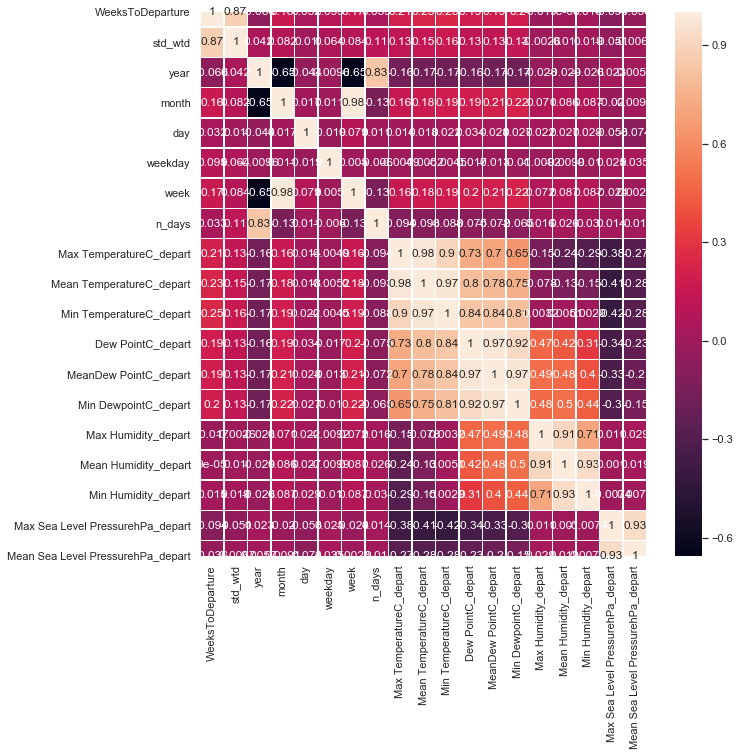

In [68]:
nom=list(importance_features.iloc[0:20,1])
import matplotlib.pyplot as plt

corr = perfect[nom].corr()
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(corr, annot=True,xticklabels=corr.columns,
        yticklabels=corr.columns, linewidths=.5, ax=ax)

In [69]:
metrics = cat_boost.eval_metrics(test_pool,
                                'RMSE',
                                ntree_start=0,
                                ntree_end=0,
                                eval_period=1,
                                plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [70]:
print("Best RMSE avec paramètres fixés aléatoirement :{}".format(min(metrics["RMSE"])))#0.3642373118047967

Best RMSE avec paramètres fixés aléatoirement :0.3890918335751356


### Optimisation Bayésienne du CatBoost

In [81]:
from sklearn.model_selection import train_test_split
perfect["log_PAX"] = y_array
y = perfect["log_PAX"]
X = perfect.drop(["log_PAX"], axis=1)
cat_algo =[c for c, d in zip (X.columns,X.dtypes) if d==np.object]
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.5, random_state=0)

In [82]:
def cat_hyp(depth, bagging_temperature,border_count,rsm, l2_leaf_reg): # Function to optimize depth and bagging temperature
    params = {"iterations": 95,
            "learning_rate": 0.1,
            "eval_metric": "RMSE",
            "verbose": False} # Default Parameters
    params["depth"] = int(round(depth)) 
    params["bagging_temperature"] = bagging_temperature
    params["l2_leaf_reg"]=l2_leaf_reg
    params["rsm"] = rsm
    #params["one_hot_max_size"]= int(round(one_hot_max_size))
    #params["subsample"] = subsample
    #params['reg_lambda'] = reg_lambda
    params["border_count"]=int(round(border_count))
  
    cv_dataset = cgb.Pool(data=X,
                  label=y, cat_features=X[cat_algo])

    scores = cgb.cv(cv_dataset,
              params,
              fold_count=8)
    return (-1.0 * np.array(scores['test-RMSE-mean'])).max() # Return maximum R-Squared value  

In [83]:
# Search space
pds = {'depth': (4, 10),
          'bagging_temperature': (0,15),
          'l2_leaf_reg': (1,100),
          'rsm' : (0.7,1),
          'border_count' : (1,255)
          #'one_hot_max_size':(1,40),
          #'subsample': (0.2,1)
          #'reg_lambda' : (1.0, 100)
          }

# Surrogate model
optimizer = BayesianOptimization(cat_hyp, pds, random_state=2100)
                                  
# Optimize
optimizer.maximize(init_points=10, n_iter=30)

|   iter    |  target   | baggin... | border... |   depth   | l2_lea... |    rsm    |
-------------------------------------------------------------------------------------
|  1        | -0.6259   |  12.71    |  6.88     |  4.521    |  34.25    |  0.8467   |
|  2        | -0.5924   |  4.499    |  246.0    |  5.351    |  11.11    |  0.9617   |
|  3        | -0.6647   |  0.1524   |  5.564    |  4.62     |  50.57    |  0.7444   |
|  4        | -0.656    |  8.707    |  204.6    |  7.274    |  46.92    |  0.9841   |
|  5        | -0.5716   |  12.96    |  182.6    |  8.759    |  10.01    |  0.9047   |
|  6        | -0.6094   |  2.393    |  155.9    |  7.369    |  21.62    |  0.9186   |
|  7        | -0.6517   |  1.977    |  185.6    |  4.532    |  64.71    |  0.756    |
|  8        | -0.6046   |  3.538    |  215.2    |  7.807    |  16.27    |  0.8382   |
|  9        | -0.6745   |  14.16    |  52.38    |  4.542    |  60.53    |  0.9055   |
|  10       | -0.6429   |  9.871    |  3.799    |  6.1

In [84]:
best_param = optimizer.max
optimizer.max

{'target': -0.49738560582719815,
 'params': {'bagging_temperature': 9.182676802284574,
  'border_count': 74.0383858597133,
  'depth': 9.033232612629044,
  'l2_leaf_reg': 1.092201200516346,
  'rsm': 0.7601916920157049}}

#### CatBoost tuné

In [85]:
from sklearn.model_selection import train_test_split
import numpy as np
perfect["log_PAX"] = y_array
y = perfect["log_PAX"]
X = perfect.drop(["log_PAX"], axis=1)
cat_algo =[c for c, d in zip (X.columns,X.dtypes) if d==np.object]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
        test_size=0.15, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=0)
from catboost import Pool, CatBoostRegressor, cv,CatBoostClassifier

train_pool = Pool(data =X_train, label = y_train, cat_features=X[cat_algo])

validation_pool = Pool(data =X_val, label = y_val, cat_features=X[cat_algo])

test_pool = Pool(data =X_test, label = y_test, cat_features=X[cat_algo])

cat_boost = CatBoostRegressor(
    iterations=25000,
    learning_rate=0.01,
    l2_leaf_reg= best_param["params"]["l2_leaf_reg"],
    depth = int(round(best_param["params"]["depth"],0)),
    bagging_temperature = best_param["params"]["bagging_temperature"],
    border_count = int(round(best_param["params"]["border_count"],0)),
    #one_hot_max_size=20.3249397,
    rsm =best_param["params"]["rsm"],
    #subsample = best_param["params"]["subsample"],
    custom_metric ='RMSE',
    od_type='Iter',
    od_wait=20,
    eval_metric='RMSE'
    )

cat_boost.fit(train_pool,
              eval_set=validation_pool,
              verbose=50,
              plot=True
             )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9797294	test: 1.0159914	best: 1.0159914 (0)	total: 48.6ms	remaining: 20m 14s
50:	learn: 0.7981266	test: 0.8400150	best: 0.8400150 (50)	total: 2.4s	remaining: 19m 32s
100:	learn: 0.6801648	test: 0.7264915	best: 0.7264915 (100)	total: 5.32s	remaining: 21m 51s
150:	learn: 0.6068886	test: 0.6575607	best: 0.6575607 (150)	total: 7.67s	remaining: 21m 2s
200:	learn: 0.5596993	test: 0.6176977	best: 0.6176977 (200)	total: 10.4s	remaining: 21m 17s
250:	learn: 0.5254355	test: 0.5885860	best: 0.5885860 (250)	total: 12.8s	remaining: 21m 1s
300:	learn: 0.4954600	test: 0.5636329	best: 0.5636329 (300)	total: 15.2s	remaining: 20m 49s
350:	learn: 0.4730402	test: 0.5455816	best: 0.5455816 (350)	total: 17.6s	remaining: 20m 36s
400:	learn: 0.4542028	test: 0.5314059	best: 0.5314059 (400)	total: 19.9s	remaining: 20m 22s
450:	learn: 0.4382015	test: 0.5195350	best: 0.5195350 (450)	total: 22.7s	remaining: 20m 38s
500:	learn: 0.4246781	test: 0.5098505	best: 0.5098505 (500)	total: 25.4s	remaining: 20m 

In [86]:
pd.set_option('display.max_rows',200)
imp= cat_boost.get_feature_importance()
importance_features = pd.DataFrame({"coeff":imp,"variables":X.columns})
importance_features.sort_values("coeff",ascending=False)

coeff                                         variables
6   14.800545                                           weekday
64  10.568685                                        is_weekend
41   8.990895                                           Arrival
0    8.890632                                         Departure
7    6.227324                                              week
1    3.903014                                  WeeksToDeparture
71   3.299269  Net_domestic_migration_rate_per_1000_hab_arrivee
5    3.203116                                               day
8    3.004354                                            n_days
35   2.330061   Net_domestic_migration_rate_per_1000_hab_depart
38   2.062904                                        lon_depart
74   2.007653                                       lon_arrivee
40   1.767005                            city_population_depart
77   1.662787                                          distance
37   1.453540                                        lat_depart
65   1.447627                                        is_holiday
76   1.260602                           city_population_arrivee
4    1.037820                                             month
2    1.011588                                           std_wtd
66   0.968874                  is_close_from_weekend_or_holiday
34   0.909532                               Average Wage_depart
39   0.894292                                  elevation_depart
73   0.880789                                       lat_arrivee
75   0.815873                                 elevation_arrivee
10   0.751542                          Mean TemperatureC_depart
68   0.713677                        Peer_capita_income_arrivee
70   0.629364                              Average Wage_arrivee
9    0.614626                           Max TemperatureC_depart
30   0.569638                             WindDirDegrees_depart
11   0.558730                           Min TemperatureC_depart
43   0.507222                         Mean TemperatureC_arrivee
72   0.492502                                  TFR 2018_arrivee
31   0.468878                          Unemployment_Rate_depart
63   0.457522                            WindDirDegrees_arrivee
69   0.445691                             Median_income_arrivee
33   0.434700                              Median_income_depart
44   0.414650                          Min TemperatureC_arrivee
36   0.402199                                   TFR 2018_depart
32   0.396592                         Peer_capita_income_depart
42   0.396328                          Max TemperatureC_arrivee
51   0.354311                 Max Sea Level PressurehPa_arrivee
48   0.335320                              Max Humidity_arrivee
59   0.324186                        Max Gust SpeedKm/h_arrivee
16   0.320083                              Mean Humidity_depart
12   0.309775                                 Dew PointC_depart
25   0.308217                        Mean Wind SpeedKm/h_depart
61   0.307841                                CloudCover_arrivee
17   0.306496                               Min Humidity_depart
50   0.305013                              Min Humidity_arrivee
45   0.290204                                Dew PointC_arrivee
15   0.287616                               Max Humidity_depart
20   0.287135                  Min Sea Level PressurehPa_depart
49   0.283748                             Mean Humidity_arrivee
3    0.272583                                              year
13   0.265442                             MeanDew PointC_depart
58   0.260803                       Mean Wind SpeedKm/h_arrivee
47   0.260630                             Min DewpointC_arrivee
14   0.250719                              Min DewpointC_depart
28   0.244287                                 CloudCover_depart
53   0.235337                 Min Sea Level PressurehPa_arrivee
18   0.233447                  Max Sea Level PressurehPa_depart
26   0.230686                         Ma

In [87]:
metrics = cat_boost.eval_metrics(test_pool,
                                'RMSE',
                                ntree_start=0,
                                ntree_end=0,
                                eval_period=1,
                                plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [88]:
print("Best RMSE avec paramètres optimisés :{}".format(min(metrics["RMSE"])))#0.3642373118047967

Best RMSE avec paramètres optimisés :0.3736491841049511


#### Limitation du bruit

In [89]:
to_keep=list(importance_features[importance_features["coeff"]>0.15]["variables"])
to_keep.append("log_PAX")

In [95]:
from sklearn.model_selection import train_test_split
import numpy as np
perfect["log_PAX"] = y_array
perfect = perfect[to_keep]
y = perfect["log_PAX"]
X = perfect.drop(["log_PAX"], axis=1)
cat_algo =[c for c, d in zip (X.columns,X.dtypes) if d==np.object]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
        test_size=0.15, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=0)
from catboost import Pool, CatBoostRegressor, cv,CatBoostClassifier

train_pool = Pool(data =X_train, label = y_train, cat_features=X[cat_algo])

validation_pool = Pool(data =X_val, label = y_val, cat_features=X[cat_algo])

test_pool = Pool(data =X_test, label = y_test, cat_features=X[cat_algo])

cat_boost = CatBoostRegressor(
    iterations=25000,
    learning_rate=0.01,
    l2_leaf_reg= best_param["params"]["l2_leaf_reg"],
    depth = int(round(best_param["params"]["depth"],0)),
    bagging_temperature = best_param["params"]["bagging_temperature"],
    border_count = int(round(best_param["params"]["border_count"],0)),
    #one_hot_max_size=20.3249397,
    rsm =best_param["params"]["rsm"],
    #subsample = best_param["params"]["subsample"],
    custom_metric ='RMSE',
    od_type='Iter',
    od_wait=20,
    eval_metric='RMSE'
    )

cat_boost.fit(train_pool,
              eval_set=validation_pool,
              verbose=50,
              plot=True
             )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9789779	test: 1.0154040	best: 1.0154040 (0)	total: 45.5ms	remaining: 18m 57s
50:	learn: 0.7983713	test: 0.8410935	best: 0.8410935 (50)	total: 2.24s	remaining: 18m 15s
100:	learn: 0.6779450	test: 0.7258632	best: 0.7258632 (100)	total: 4.34s	remaining: 17m 50s
150:	learn: 0.6059261	test: 0.6597096	best: 0.6597096 (150)	total: 6.56s	remaining: 17m 59s
200:	learn: 0.5577733	test: 0.6187552	best: 0.6187552 (200)	total: 8.82s	remaining: 18m 7s
250:	learn: 0.5209291	test: 0.5859635	best: 0.5859635 (250)	total: 11s	remaining: 18m 9s
300:	learn: 0.4927802	test: 0.5625305	best: 0.5625305 (300)	total: 13.3s	remaining: 18m 13s
350:	learn: 0.4695947	test: 0.5440889	best: 0.5440889 (350)	total: 15.6s	remaining: 18m 16s
400:	learn: 0.4520144	test: 0.5304756	best: 0.5304756 (400)	total: 17.9s	remaining: 18m 18s
450:	learn: 0.4361364	test: 0.5183107	best: 0.5183107 (450)	total: 20.3s	remaining: 18m 23s
500:	learn: 0.4222881	test: 0.5090657	best: 0.5090657 (500)	total: 22.6s	remaining: 18m 2

In [96]:
metrics = cat_boost.eval_metrics(test_pool,
                                'RMSE',
                                ntree_start=0,
                                ntree_end=0,
                                eval_period=1,
                                plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [97]:
print("Best RMSE avec paramètres optimisés :{}".format(min(metrics["RMSE"])))#0.3642373118047967

Best RMSE avec paramètres optimisés :0.3730401582203304


On voit ici que le résultat de l'optimisation est intéressante. En effet, sur un si petit volume de données, nous constatons que le modèle réagit bien en terme de score mais aussi en terme d'optimisation. Il faudra maintenant observer les résultats sur le jeu de données complet. 